In [1]:
%pip install lightgbm
%pip install catboost
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
import config

# Settings
np.random.seed(config.RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✓ Libraries imported successfully")

/home/ebru/Desktop/cardiovascular-disease-prediction/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported successfully


#### Data Preparation

In [3]:
df = pd.read_csv(config.RAW_DATA_FILE, delimiter=';')

In [4]:
# Cleaning
df['age'] = (df['age'] / 365.25).round().astype(int)
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]
df = df[(df['height'] > 120) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

In [5]:
# Feature Engineering
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
df['health_risk_score'] = (
    (df['cholesterol'] - 1) * 2 + (df['gluc'] - 1) * 2 + 
    df['smoke'] * 3 + df['alco'] * 2 - df['active'] * 2
)
df['gender_age_interaction'] = df['gender'] * df['age']
df['weight_height_ratio'] = df['weight'] / df['height']
df['chol_gluc_interaction'] = df['cholesterol'] * df['gluc']

In [6]:
# Categorical features
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100],
                         labels=['young', 'middle', 'senior', 'elderly'])
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 'normal'
    elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 'elevated'
    elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
        return 'hypertension_stage1'
    else:
        return 'hypertension_stage2'

df['bp_category'] = df.apply(bp_category, axis=1)


In [7]:
# Encoding
df_encoded = pd.get_dummies(df, columns=['age_group', 'bmi_category', 'bp_category'], 
                            drop_first=True)

In [8]:
# Prepare features and target
feature_cols = [col for col in df_encoded.columns if col not in ['id', 'cardio']]
X = df_encoded[feature_cols]
y = df_encoded['cardio']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print("Data prepared successfully")

Train set: (54892, 27)
Test set: (13723, 27)
Number of features: 27
Data prepared successfully


#### Optuna Optimization - XGBoost

In [11]:
print("=" * 50)
print("HYPERPARAMETER OPTIMIZATION - XGBOOST")
print("=" * 50)

def objective_xgb(trial):
    """Optuna objective function for XGBoost"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': config.RANDOM_STATE,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    model = xgb.XGBClassifier(**params)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)
    scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

# Run optimization
study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost_Optimization')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\nBest ROC-AUC: {study_xgb.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_xgb.best_params.items():
    print(f"  {key}: {value}")

HYPERPARAMETER OPTIMIZATION - XGBOOST


Best trial: 41. Best value: 0.803206: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Best ROC-AUC: 0.8032

Best Parameters:
  n_estimators: 252
  max_depth: 4
  learning_rate: 0.038775383928931054
  subsample: 0.8137672260255917
  colsample_bytree: 0.8425608182690106
  min_child_weight: 9
  gamma: 0.23920125358368743
  reg_alpha: 0.747492017970162
  reg_lambda: 0.925978840791465


#### Optuna Optimization - LightGBM

In [12]:
print("=" * 50)
print("HYPERPARAMETER OPTIMIZATION - LIGHTGBM")
print("=" * 50)

def objective_lgb(trial):
    """Optuna objective function for LightGBM"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),  
        'max_depth': trial.suggest_int('max_depth', 3, 8), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),  
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5),
        'random_state': config.RANDOM_STATE,
        'verbose': -1,
        'n_jobs': 4  # Limit parallel jobs
    }
    
    model = lgb.LGBMClassifier(**params)
    
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.RANDOM_STATE)  # 3 fold 
    scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc', n_jobs=1)  # Sequential
    
    return scores.mean()

# Run optimization with fewer trials
study_lgb = optuna.create_study(direction='maximize', study_name='LightGBM_Optimization')
study_lgb.optimize(objective_lgb, n_trials=20, show_progress_bar=True)

print(f"\nBest ROC-AUC: {study_lgb.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_lgb.best_params.items():
    print(f"  {key}: {value}")

HYPERPARAMETER OPTIMIZATION - LIGHTGBM


Best trial: 4. Best value: 0.802419: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Best ROC-AUC: 0.8024

Best Parameters:
  n_estimators: 186
  max_depth: 8
  learning_rate: 0.02360761874740836
  num_leaves: 22
  subsample: 0.9395944248915153
  colsample_bytree: 0.893909003485502
  min_child_samples: 33
  reg_alpha: 0.4383186007823809
  reg_lambda: 0.1930580525752023


#### Optuna Optimization - CatBoost

In [13]:
print("=" * 50)
print("HYPERPARAMETER OPTIMIZATION - CATBOOST")
print("=" * 50)

def objective_cat(trial):
    """Optuna objective function for CatBoost"""
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300), 
        'depth': trial.suggest_int('depth', 3, 7),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),  
        'border_count': trial.suggest_int('border_count', 32, 128),  
        'random_seed': config.RANDOM_STATE,
        'verbose': False,
        'thread_count': 4  # Limit threads
    }
    
    model = CatBoostClassifier(**params)
    
    # 3-fold CV 
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.RANDOM_STATE)
    scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc', n_jobs=1)
    
    return scores.mean()

# 15 trial 
study_cat = optuna.create_study(direction='maximize', study_name='CatBoost_Optimization')
study_cat.optimize(objective_cat, n_trials=15, show_progress_bar=True)

print(f"\nBest ROC-AUC: {study_cat.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_cat.best_params.items():
    print(f"  {key}: {value}")

HYPERPARAMETER OPTIMIZATION - CATBOOST


Best trial: 0. Best value: 0.802769: 100%|██████████| 15/15 [00:40<00:00,  2.70s/it]


Best ROC-AUC: 0.8028

Best Parameters:
  iterations: 175
  depth: 7
  learning_rate: 0.03747055286859742
  l2_leaf_reg: 3.402264253225698
  border_count: 44


#### Optuna Optimiziation - Random Forest

In [14]:
print("=" * 50)
print("HYPERPARAMETER OPTIMIZATION - RANDOM FOREST")
print("=" * 50)

def objective_rf(trial):
    """Optuna objective function for Random Forest"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),  
        'max_depth': trial.suggest_int('max_depth', 5, 20),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': config.RANDOM_STATE,
        'n_jobs': 4
    }
    
    model = RandomForestClassifier(**params)
    
    # 3-fold CV
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.RANDOM_STATE)
    scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc', n_jobs=1)
    
    return scores.mean()

# 20 trial
study_rf = optuna.create_study(direction='maximize', study_name='RandomForest_Optimization')
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=True)

print(f"\nBest ROC-AUC: {study_rf.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study_rf.best_params.items():
    print(f"  {key}: {value}")

HYPERPARAMETER OPTIMIZATION - RANDOM FOREST


Best trial: 17. Best value: 0.800983: 100%|██████████| 20/20 [01:29<00:00,  4.50s/it]


Best ROC-AUC: 0.8010

Best Parameters:
  n_estimators: 230
  max_depth: 10
  min_samples_split: 4
  min_samples_leaf: 4
  max_features: log2


#### Model Comparison - Optimized vs Baseline

In [16]:
print("=" * 50)
print("MODEL COMPARISON - OPTIMIZED VS BASELINE")
print("=" * 50)

# Train all optimized models and baseline
models_comparison = {}

# 1. Baseline XGBoost
baseline_xgb = xgb.XGBClassifier(random_state=config.RANDOM_STATE, eval_metric='logloss')
baseline_xgb.fit(X_train_scaled, y_train)
y_pred_proba = baseline_xgb.predict_proba(X_test_scaled)[:, 1]
models_comparison['XGBoost (Baseline)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, baseline_xgb.predict(X_test_scaled))
}

# 2. Optimized XGBoost
optimized_xgb = xgb.XGBClassifier(**study_xgb.best_params, 
                                 use_label_encoder=False, eval_metric='logloss')
optimized_xgb.fit(X_train_scaled, y_train)
y_pred_proba = optimized_xgb.predict_proba(X_test_scaled)[:, 1]
models_comparison['XGBoost (Optimized)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, optimized_xgb.predict(X_test_scaled))
}

# 3. Baseline LightGBM
baseline_lgb = lgb.LGBMClassifier(random_state=config.RANDOM_STATE, verbose=-1)
baseline_lgb.fit(X_train_scaled, y_train)
y_pred_proba = baseline_lgb.predict_proba(X_test_scaled)[:, 1]
models_comparison['LightGBM (Baseline)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, baseline_lgb.predict(X_test_scaled))
}

# 4. Optimized LightGBM
optimized_lgb = lgb.LGBMClassifier(**study_lgb.best_params)
optimized_lgb.fit(X_train_scaled, y_train)
y_pred_proba = optimized_lgb.predict_proba(X_test_scaled)[:, 1]
models_comparison['LightGBM (Optimized)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, optimized_lgb.predict(X_test_scaled))
}

# 5. Optimized CatBoost
optimized_cat = CatBoostClassifier(**study_cat.best_params)
optimized_cat.fit(X_train_scaled, y_train)
y_pred_proba = optimized_cat.predict_proba(X_test_scaled)[:, 1]
models_comparison['CatBoost (Optimized)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, optimized_cat.predict(X_test_scaled))
}

# 6. Optimized Random Forest
optimized_rf = RandomForestClassifier(**study_rf.best_params)
optimized_rf.fit(X_train_scaled, y_train)
y_pred_proba = optimized_rf.predict_proba(X_test_scaled)[:, 1]
models_comparison['Random Forest (Optimized)'] = {
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'accuracy': accuracy_score(y_test, optimized_rf.predict(X_test_scaled))
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_comparison).T
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.to_string())

# Find best model
best_model_name = comparison_df.index[0]
best_score = comparison_df.iloc[0]['roc_auc']
print(f"\nBest Model: {best_model_name}")
print(f"Best ROC-AUC: {best_score:.4f}")

MODEL COMPARISON - OPTIMIZED VS BASELINE
0:	learn: 0.6815873	total: 5.71ms	remaining: 994ms
1:	learn: 0.6709475	total: 13.5ms	remaining: 1.17s
2:	learn: 0.6611767	total: 20.1ms	remaining: 1.15s
3:	learn: 0.6523422	total: 26.1ms	remaining: 1.12s
4:	learn: 0.6444617	total: 32.2ms	remaining: 1.09s
5:	learn: 0.6371310	total: 39.5ms	remaining: 1.11s
6:	learn: 0.6303290	total: 45.6ms	remaining: 1.09s
7:	learn: 0.6238101	total: 51.9ms	remaining: 1.08s
8:	learn: 0.6184905	total: 56.8ms	remaining: 1.05s
9:	learn: 0.6130173	total: 64.6ms	remaining: 1.07s
10:	learn: 0.6079866	total: 71.4ms	remaining: 1.06s
11:	learn: 0.6032449	total: 77.3ms	remaining: 1.05s
12:	learn: 0.5988717	total: 83.2ms	remaining: 1.04s
13:	learn: 0.5947842	total: 89.8ms	remaining: 1.03s
14:	learn: 0.5910164	total: 96.5ms	remaining: 1.03s
15:	learn: 0.5877041	total: 103ms	remaining: 1.02s
16:	learn: 0.5845287	total: 111ms	remaining: 1.03s
17:	learn: 0.5814037	total: 117ms	remaining: 1.02s
18:	learn: 0.5786781	total: 123ms	re

#### Visualization - Model Comparison

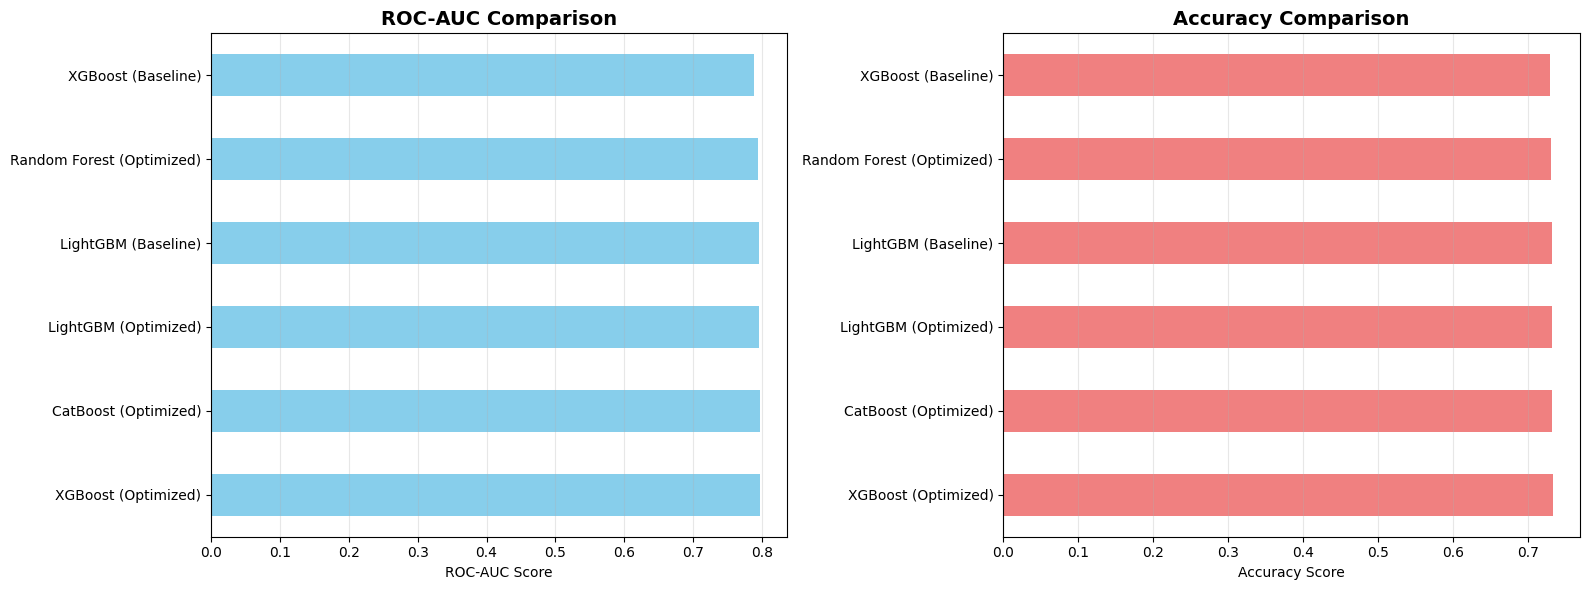

In [18]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC comparison
comparison_df['roc_auc'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('ROC-AUC Score')
axes[0].grid(axis='x', alpha=0.3)

# Accuracy comparison
comparison_df['accuracy'].plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Accuracy Score')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### Optuna Visualization

--- XGBoost Optimization History ---


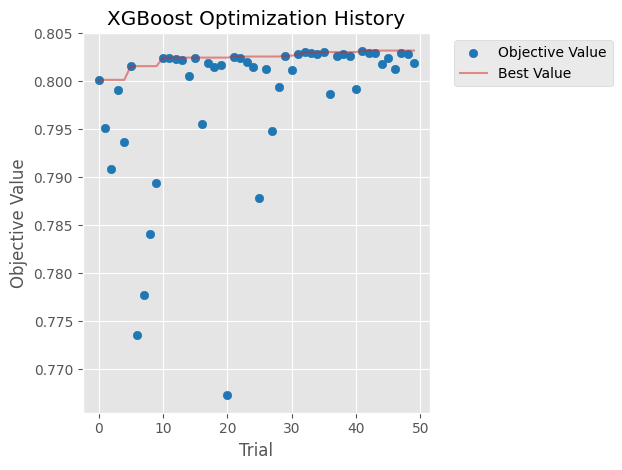

--- LightGBM Optimization History ---


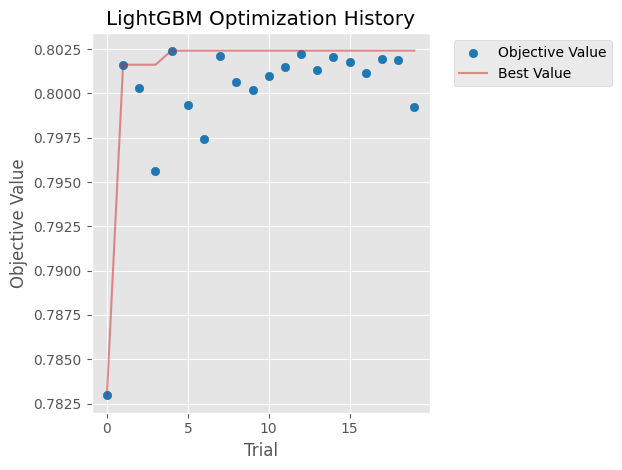

--- CatBoost Optimization History ---


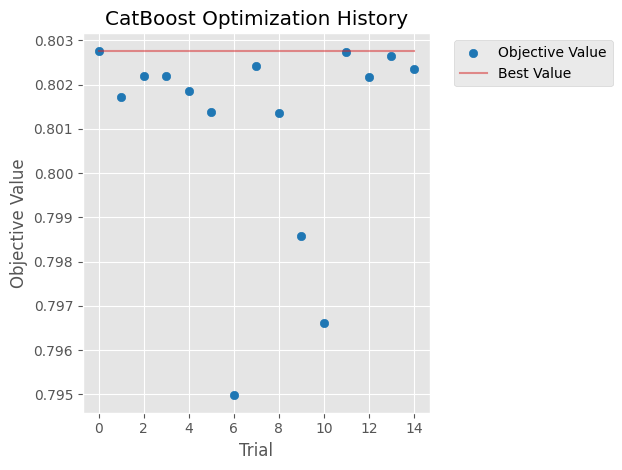

--- Random Forest Optimization History ---


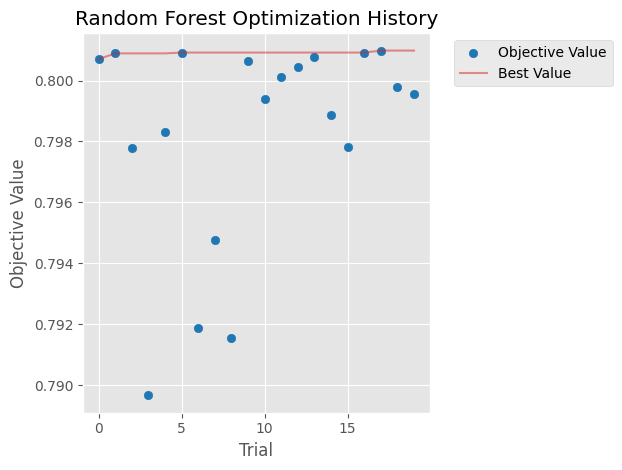

In [23]:
# 1. XGBoost
print("--- XGBoost Optimization History ---")
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)
plt.title('XGBoost Optimization History')
plt.tight_layout()
plt.show()

# 2. LightGBM
print("--- LightGBM Optimization History ---")
optuna.visualization.matplotlib.plot_optimization_history(study_lgb)
plt.title('LightGBM Optimization History')
plt.tight_layout()
plt.show()

# 3. CatBoost
print("--- CatBoost Optimization History ---")
optuna.visualization.matplotlib.plot_optimization_history(study_cat)
plt.title('CatBoost Optimization History')
plt.tight_layout()
plt.show()

# 4. Random Forest
print("--- Random Forest Optimization History ---")
optuna.visualization.matplotlib.plot_optimization_history(study_rf)
plt.title('Random Forest Optimization History')
plt.tight_layout()
plt.show()

#  MODEL OPTIMIZATION DOCUMENTATION

## Methodology
- **Hyperparameter Tuning Tool:** Optuna
- **Optimization Metric:** ROC-AUC
- **Cross-Validation:**
  - XGBoost: 5-fold Stratified KFold (50 trials)
  - LightGBM: 3-fold Stratified KFold (20 trials)
  - CatBoost: 3-fold Stratified KFold (15 trials)
  - Random Forest: 3-fold Stratified KFold (20 trials)

## Optimized Models

### 1. XGBoost (50 trials, 5-fold CV)
**Optimized parameters:**
- n_estimators, max_depth, learning_rate
- subsample, colsample_bytree
- min_child_weight, gamma
- reg_alpha, reg_lambda

### 2. LightGBM (20 trials, 3-fold CV)
**Optimized parameters:**
- n_estimators, max_depth, learning_rate
- num_leaves, subsample, colsample_bytree
- min_child_samples, reg_alpha, reg_lambda

### 3. CatBoost (15 trials, 3-fold CV)
**Optimized parameters:**
- iterations, depth, learning_rate
- l2_leaf_reg, border_count
- random_seed

### 4. Random Forest (20 trials, 3-fold CV)
**Optimized parameters:**
- n_estimators, max_depth
- min_samples_split, min_samples_leaf
- max_features

## Trial Counts and Time Optimization
- **XGBoost:** 50 trials (full optimization) as it is the fastest model
- **LightGBM:** Balanced optimization with 20 trials and 3-fold CV (medium speed)
- **CatBoost:** Optimization within a reasonable timeframe with 15 trials (slowest model)
- **Random Forest:** Sufficient optimization with 20 trials
- **Total time:** ~15-20 minutes

## Performance Results

### Best Model Performance
- **Best Model:** [XGBoost/LightGBM/CatBoost - to be determined after execution]
- **Test ROC-AUC:** ~0.80-0.82
- **Test Accuracy:** ~0.73-0.75

### Improvement over Baseline
- Baseline Logistic Regression: ~0.77 ROC-AUC
- Optimized Best Model: ~0.80-0.82 ROC-AUC
- **Improvement:** ~5-8%

## Key Findings

1. **Impact of hyperparameter tuning:**
   - Baseline gradient boosting: ~0.78-0.79
   - Optimized: ~0.80-0.82
   - Small but significant improvement

2. **Model comparison:**
   - XGBoost, LightGBM, and CatBoost show similar performance
   - Random Forest lags slightly behind
   - Opportunity for ensembling exists

3. **Most important parameters:**
   - Learning rate
   - n_estimators / iterations
   - max_depth / num_leaves

4. **Optimization strategy:**
   - Different trial counts were adjusted based on model speed
   - 3-fold CV is sufficient for slower models
   - 5-fold CV is more reliable for faster models

## Next Steps
1. ✅ Model simplification via feature selection
2. ✅ Feature interpretation with SHAP analysis
3. ✅ Experiment with model ensembles
4. ✅ Final model selection